Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.191934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 183185
[LightGBM] [Info] Number of data points in the train set: 751254, number of used features: 918
[LightGBM] [Info] Start training from score 0.000000
[1]	valid_0's l1: 0.329377	valid_0's l2: 0.999109
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l1: 0.329116	valid_0's l2: 0.998422
[3]	valid_0's l1: 0.328897	valid_0's l2: 0.997864
[4]	valid_0's l1: 0.328599	valid_0's l2: 0.997225
[5]	valid_0's l1: 0.328226	valid_0's l2: 0.996393
[6]	valid_0's l1: 0.328	valid_0's l2: 0.995773
[7]	valid_0's l1: 0.32768	valid_0's l2: 0.995054
[8]	valid_0's l1: 0.327593	valid_0's l2: 0.994611
[9]	valid_0's l1: 0.327301	valid_0's l2: 0.993919
[10]	valid_0's l1: 0.327037	valid_0's l2: 0.9933
[11]	valid_0's l1: 0.326785	valid_0's l2: 0.992645
[12]	valid_0's l1: 0.32

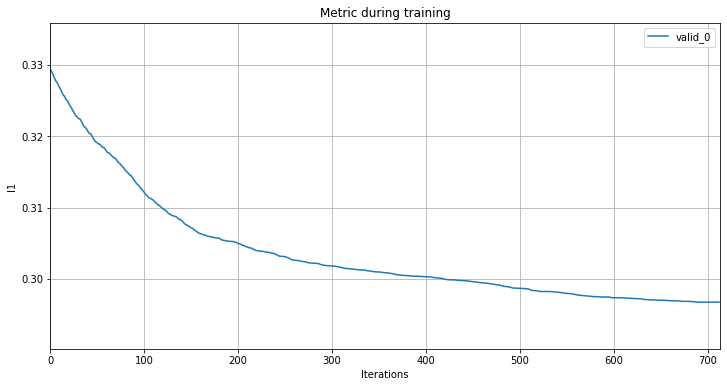

In [1]:
from sklearn.metrics import mean_squared_error
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
from pytorch_models import get_local_features
import numpy as np


def predict():
    data_folder = "./predict_data/"
    candidate_features, customer_features, y_train = get_local_features(data_folder)
    candidate_features_test, customer_features_test, y_test = get_local_features(data_folder, eval=True)
    candidates = candidate_features.reshape(len(y_train), -1)
    customers = customer_features.reshape(len(y_train), -1)
    X_train = np.concatenate((candidates, customers), axis=1).astype(np.float32)
    candidates_test = candidate_features_test.reshape(len(y_test), -1)
    customers_test = customer_features_test.reshape(len(y_test), -1)
    X_test = np.concatenate((candidates_test, customers_test), axis=1).astype(np.float32)
    
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 31,
        'learning_rate': 0.01,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 1
    }
    evals_result = {}
    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=lgb_eval,
                    callbacks=[lgb.log_evaluation(), lgb.record_evaluation(evals_result), lgb.early_stopping(stopping_rounds=10)])

    # print('Saving model...')
    # save model to file
    # gbm.save_model('model.txt')

    print('Starting predicting...')
    # predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    gbm.save_model("lgb_model.pt", num_iteration=gbm.best_iteration)
    # eval
    rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
    print(f'The RMSE of prediction is: {rmse_test}')
    lgb.plot_metric(evals_result, metric='l1', figsize=(12, 6))
    return y_test, y_pred
    
y_test, y_pred = predict()
print("real: ", y_test[:10])
print("pred: ", y_pred[:10])